In [55]:
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

In [65]:
GRID_SIZE = 20
NUM_AGENTS = 30
NUM_FOODS = 10

STEP_SIZE = 1
EAT_THRESHOLD = 2

N_DAYS = 30

SEED = 53

In [66]:
class Food:
    def __init__(self, position: tuple):
        self.position = position  # coordinates of food on env grid
        self.is_eaten = False  # can be alive or eaten
        
    def __repr__(self):
        return f"position={self.position}, is_eaten={self.is_eaten}"

In [67]:
class Agent:
    def __init__(self, position: tuple):
        self.position = position  # oordinates of agent on env grid
        self.energy = np.inf  # energy to be consumed walking
        self.food_eaten = 0  # amound of food items eaten
        self.is_dead = False # can be alive or dead

    def move(self, new_position):
        # move randomly on x or y by step size
        x, y = new_position
        self.position = x, y
        # consume energy equal to step size
        self.energy -= STEP_SIZE 
        
    def eat(self, food):
        # eat food and increase counter
        if self.food_eaten < 2:
            self.food_eaten += 1
            food.is_eaten = True

    def __repr__(self):
        return f"position={self.position}, is_dead={self.is_dead}, food_eaten={self.food_eaten}\n"

In [68]:
class Environment:
    np.random.seed(SEED)
    
    def __init__(self, grid_size=20, num_agents=10, num_foods=2):
        self.grid_size = grid_size
        self.num_foods = num_foods
        self.num_agents = num_agents
        self.foods = []
        self.agents = []
        self.initialize()
     
    def add_food(self):  # add food on the grid randomly
        for _ in range(self.num_foods):
            x = np.random.uniform(0, self.grid_size)
            y = np.random.uniform(0, self.grid_size)
            food = Food((x, y))
            self.foods.append(food)

    def add_agents(self):  # add agents on the grid edges randomly
        for _ in range(self.num_agents):
            x, y = np.random.uniform(0, self.grid_size, size=2)
            if np.random.random() > 0.5:
                if np.random.random() > 0.5:
                    x = 0
                else:
                    x = self.grid_size
            else:
                if np.random.random() > 0.5:
                    y = 0
                else:
                    y = self.grid_size
            agent = Agent((x, y))
            self.agents.append(agent)
            
    def initialize(self):  # inizialize grid with random food and agents
        self.add_food()
        self.add_agents()

    def move_agent(self, agent):  # agent moves on the environment
        x, y = agent.position
        step = STEP_SIZE if np.random.random() > 0.5 else - STEP_SIZE
        if np.random.random() > 0.5:
            new_x = x
            new_y = (y + step) % self.grid_size
        else:
            new_x = (x + step) % self.grid_size
            new_y = y 
        new_position = new_x, new_y
        agent.move(new_position)
        
    def interact_food(self, agent):  # agent eats whatever in the sorrounding < thershold
        for food in self.foods:
            distance = np.linalg.norm(np.array(agent.position) - np.array(food.position))
            if distance < EAT_THRESHOLD and not food.is_eaten:
                agent.eat(food)
        self.foods = [food for food in self.foods if not food.is_eaten]
                
    def is_game_over(self):  # game over when no more food is left
        game_over = (len(env.foods) == 0 or len(env.agents) <= 0)
        return game_over

    def visualize(self):
        fig, ax = plt.subplots()
        if self.foods:
            food_x, food_y = zip(*[food.position for food in self.foods])
        else:
            food_x, food_y = None, None
        ax.scatter(food_x, food_y, c='red', label='Food')
        agent_x, agent_y = zip(*[agent.position for agent in self.agents])
        ax.scatter(agent_x, agent_y, c='blue', label='Agents')
        ax.set_xlim(0, self.grid_size)
        ax.set_ylim(0, self.grid_size)
        ax.set_xlabel('X-coordinate')
        ax.set_ylabel('Y-coordinate')
        ax.legend()
        plt.pause(0.1)  
        plt.show() 
        
    def __repr__(self):
        return f"Agents: {self.agents}, \nFood: {self.foods}"

In [69]:
class DayLoop:
    
    def __init__(self, env):
        self.env = env
        self.time_elapsed = 0
                   
    def step(self):
        env = self.env
        for agent in env.agents:
            env.move_agent(agent)
            env.interact_food(agent)
            # env.select_agent(agent)
        
    def restart(self):  # restart the grid (when game is over at the end of the day with new amount of agents)
        self.env.foods = []
        self.env.agents = []
        self.env.initialize()
        
    def update(self, verbose=False):
        env = self.env
        is_alive = (lambda x: x.energy >= 0 and x.food_eaten >=1)
        env.agents = [agent for agent in env.agents if is_alive(agent)]
        num_agents_survived = len(env.agents)
        num_agents_reproduced = len([agent for agent in env.agents if agent.food_eaten == 2])
        if verbose:
            print(f"agents survived = {num_agents_survived}")
            print(f"agents reproduced = {num_agents_reproduced}")
        env.num_agents = num_agents_survived + num_agents_reproduced
        
    def main_loop(self, show_viz=False):
        env = self.env
        done = False
        while not done:
            self.step()
            done = env.is_game_over()
            if show_viz:
                env.visualize()
        self.update(verbose=False)

In [70]:
env = Environment(grid_size=GRID_SIZE, num_agents=NUM_AGENTS, num_foods=NUM_FOODS)
day = DayLoop(env)

In [71]:
# main loop over N_DAYS passed as global variable
# store the agents amount at each day to study relation with food

agents_per_day = np.zeros(N_DAYS, dtype=int)

for i in range(N_DAYS):
    agents_per_day[i] = env.num_agents
    day.main_loop()
    day.restart()

In [72]:
agents_per_day

array([30, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

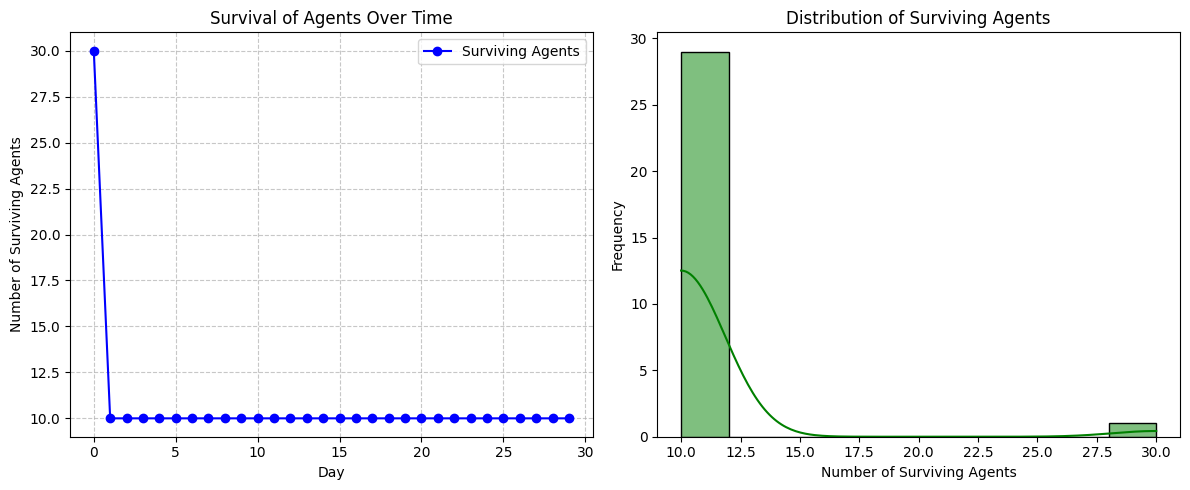

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(agents_per_day, marker='o', linestyle='-', color='b', label='Surviving Agents')
ax1.set_xlabel('Day')
ax1.set_ylabel('Number of Surviving Agents')
ax1.set_title('Survival of Agents Over Time')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

sns.histplot(agents_per_day, ax=ax2, bins=10, color='g', kde=True)
ax2.set_xlabel('Number of Surviving Agents')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Surviving Agents')

plt.tight_layout()
plt.show()